# Import Libraries

In [13]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, mean_squared_error, 
                             confusion_matrix, classification_report)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from datetime import datetime
from functools import partial
import shap
import itertools
import math
import json
import os
import warnings
import re
import pickle
import time

# LightGBM and XGBoost
import lightgbm as lgb
import xgboost as xgb
from xgboost import DMatrix

# TensorFlow / Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Clustering
from sklearn.cluster import KMeans

# Displaying Images
from IPython.display import Image

# Ignore Warnings
warnings.filterwarnings("ignore")



# Import file here

In [14]:
# Load Data
df = pd.read_csv("cleaned data/cleaned_data_split.csv")



# Supervised Models Pipeline
- Random Forest
- XGBoost
- LGBM
- Logistic Regression

In [15]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import DMatrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import KFold, TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import json
from functools import partial
import warnings
warnings.filterwarnings("ignore")

class UnifiedModelTrainer:
    def __init__(self, random_state=2024):
        self.random_state = random_state
    
    ######################
    ## Data Preparation ##
    ######################
    
    def prepare_data(self, df, features, target):
        """Prepare train, validation, test and out-of-time datasets"""
        train_valid = df[df['X_fold'].isin(['train', 'valid'])]
        test = df[df['X_fold'] == 'test']
        oot = df[df['X_fold'] == 'oot']
        
        X_train_valid = train_valid[features]
        y_train_valid = train_valid[target]
        
        X_test = test[features]
        y_test = test[target]
        
        X_oot = oot[features]
        y_oot = oot[target]
        
        return (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot)

    ##############################
    ## Evaluation Model Metrics ##
    ##############################
    def evaluate_model(self, model, X_test, y_test, X_oot, y_oot):
        """Evaluate model performance on test and OOT datasets"""
        if isinstance(model, lgb.Booster) or isinstance(model, RandomForestClassifier):
            pred_test = model.predict(X_test)
            pred_oot = model.predict(X_oot)
    
        else:
            pred_test = model.predict_proba(X_test)[:, 1]
            pred_oot = model.predict_proba(X_oot)[:, 1]
        
        metrics = {}
        metrics['test_auc'] = roc_auc_score(y_test, pred_test)
        metrics['oot_auc'] = roc_auc_score(y_oot, pred_oot)
        #metrics['recall'] = recall_score(y_test, pred_test)
        
        # Calculate additional metrics for different thresholds
        threshold_metrics = {}
        for threshold in [0.5, 0.8, 0.85, 0.9, 0.95]:
            pred_test_binary = (pred_test > threshold).astype(int)
            pred_oot_binary = (pred_oot > threshold).astype(int)
            
            threshold_metrics[f'threshold_{threshold}'] = {
                'test': {
                    'precision': precision_score(y_test, pred_test_binary),
                    'recall': recall_score(y_test, pred_test_binary),
                    'f1': f1_score(y_test, pred_test_binary),
                    'auc': roc_auc_score(y_test, pred_test_binary)
                },
                'oot': {
                    'precision': precision_score(y_oot, pred_oot_binary),
                    'recall': recall_score(y_oot, pred_oot_binary),
                    'f1': f1_score(y_oot, pred_oot_binary),
                    'auc': roc_auc_score(y_oot, pred_oot_binary)

                }
            }
        
        metrics['threshold_metrics'] = threshold_metrics
        return metrics
        
    ############################
    ## Hyperparameter Tunning ##
    ############################
    def create_search_space(self, model_type):
        """Define complete search space including data preparation and model parameters."""
        
        # Common parameters
        common_params = {
            'k_folds': hp.choice('k_folds', [3, 5, 7, 10]),
            'k_split': hp.choice('k_split', ['non_ts', 'ts']),
            
            # Feature selection parameters
            'f_method': hp.choice('f_method', [
                'all',  # Use all features
                'kbest_f',  # SelectKBest with f_classif
                'kbest_mi',  # SelectKBest with mutual_info_classif
                'l1',  # L1-based feature selection
                'tree_importance'  # Tree-based feature importance
            ]),
            'num_feats': hp.choice('num_feats', [20, 25, 30, 35, 'all']),
            
            # Scaling parameters
            'scaler': hp.choice('scaler', [
                'noscaler',
                'standard',
                'minmax',
                'robust'
            ]),
            
            # Fixed parameters
            'SEED': self.random_state
        }
        
        if model_type == 'lgbm':
            # LightGBM specific parameters
            lgbm_params = {
                'num_leaves': hp.quniform('num_leaves', 15, 127, 1),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
                'feature_fraction': hp.uniform('feature_fraction', 0.6, 0.9),
                'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 0.9),
                'bagging_freq': hp.quniform('bagging_freq', 2, 10, 1),
                'min_child_samples': hp.quniform('min_child_samples', 10, 150, 1),
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50)
            }
            return {**common_params, **lgbm_params}

        elif model_type == 'xgb':
            # XGBoost specific parameters
            xgb_params = {
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
                'subsample': hp.uniform('subsample', 0.6, 1.0),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
                'min_child_weight': hp.quniform('min_child_weight', 1, 7, 1),
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50)
            }
            return {**common_params, **xgb_params}
        
        elif model_type == 'rf':
            rf_params = {
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
            }
            return {**common_params, **rf_params}
        
        else:
            raise ValueError("Invalid model type. Please choose 'lgbm' or 'xgb'.")

    
    def apply_feature_selection(self, X, y, method, num_feats):
        """Apply feature selection based on specified method"""
        if method == 'all' or num_feats == 'all':
            return X
            
        n_features = min(num_feats, X.shape[1])
        
        if method == 'kbest_f':
            selector = SelectKBest(score_func=f_classif, k=n_features)
        elif method == 'kbest_mi':
            selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
        elif method == 'l1':
            from sklearn.linear_model import LogisticRegression
            selector = LogisticRegression(penalty='l1', solver='saga', random_state=self.random_state)
            selector.fit(X, y)
            mask = np.abs(selector.coef_[0]) > 0
            return X.iloc[:, mask]
        elif method == 'tree_importance':
            model = lgb.LGBMClassifier(random_state=self.random_state)
            model.fit(X, y)
            importance = pd.Series(model.feature_importances_, index=X.columns)
            selected_features = importance.nlargest(n_features).index
            return X[selected_features]
            
        if method in ['kbest_f', 'kbest_mi']:
            selector.fit(X, y)
            mask = selector.get_support()
            return X.iloc[:, mask]
            
        return X
    
    def plot_results(self, metrics, output_dir):
        """Create and save visualization of results"""
        # Plot threshold performance
        plt.figure(figsize=(12, 6))
        thresholds = sorted(metrics['threshold_metrics'].keys(), 
                          key=lambda x: float(x.split('_')[1]))
        
        test_precision = [metrics['threshold_metrics'][t]['test']['precision'] 
                         for t in thresholds]
        oot_precision = [metrics['threshold_metrics'][t]['oot']['precision'] 
                        for t in thresholds]
        
        plt.plot(thresholds, test_precision, label='Test Precision')
        plt.plot(thresholds, oot_precision, label='OOT Precision')
        plt.xlabel('Threshold')
        plt.ylabel('Precision')
        plt.title('Model Performance Across Thresholds')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/threshold_performance.png")
        plt.close()
    
    def apply_scaling(self, X_train, X_test, X_oot, scaler_type):
        """Apply scaling transformation to the data"""
        if scaler_type == 'noscaler':
            return X_train, X_test, X_oot
            
        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'minmax':
            scaler = MinMaxScaler()
        elif scaler_type == 'robust':
            scaler = RobustScaler()
            
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        X_oot_scaled = pd.DataFrame(
            scaler.transform(X_oot),
            columns=X_oot.columns,
            index=X_oot.index
        )
        
        return X_train_scaled, X_test_scaled, X_oot_scaled
    
    def get_cv_splitter(self, k_split, k_folds):
        """Get cross-validation splitter based on specified method"""
        if k_split == 'non_ts':
            return KFold(n_splits=k_folds, shuffle=True, random_state=self.random_state)
        else:
            return TimeSeriesSplit(n_splits=k_folds)

###########################################
## Objective Functions for LGBM, XGB, RF ##
###########################################

    def objective_lgb(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Enhanced objective function for LightGBM optimization"""
        try:
            # Apply feature selection
            X_train_selected = self.apply_feature_selection(
                X_train, y_train, space['f_method'], space['num_feats']
            )
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            
            # Apply scaling
            X_train_processed, X_test_processed, X_oot_processed = self.apply_scaling(
                X_train_selected, X_test_selected, X_oot_selected, space['scaler']
            )
            
            # Create CV splitter
            cv_splitter = self.get_cv_splitter(space['k_split'], int(space['k_folds']))
            
            # Prepare LightGBM parameters
            params = {
                'objective': 'binary',
                'metric': 'auc',#auc
                'boosting_type': 'gbdt',
                'num_leaves': int(space['num_leaves']),
                'learning_rate': space['learning_rate'],
                'feature_fraction': space['feature_fraction'],
                'bagging_fraction': space['bagging_fraction'],
                'bagging_freq': int(space['bagging_freq']),
                'min_child_samples': int(space['min_child_samples']),
                'max_depth': int(space['max_depth']),
                'n_estimators': int(space['n_estimators']),
                'verbose': -1,
                'random_state': space['SEED']
            }
            
            # Cross-validation scores
            cv_scores = []
            for train_idx, valid_idx in cv_splitter.split(X_train_processed):
                X_fold_train = X_train_processed.iloc[train_idx]
                y_fold_train = y_train.iloc[train_idx]
                X_fold_valid = X_train_processed.iloc[valid_idx]
                y_fold_valid = y_train.iloc[valid_idx]
                
                train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
                valid_data = lgb.Dataset(X_fold_valid, label=y_fold_valid, reference=train_data)
                
                model = lgb.train(
                    params,
                    train_data,
                    valid_sets=[valid_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=20)]
                )
                
                pred_valid = model.predict(X_fold_valid)
                cv_scores.append(roc_auc_score(y_fold_valid, pred_valid)) # modify metric here for tuning for other metrics
            
            # Train final model on full training data
            train_data = lgb.Dataset(X_train_processed, label=y_train)
            valid_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)
            
            final_model = lgb.train(
                params,
                train_data,
                valid_sets=[valid_data],
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
            )
            
            # Calculate metrics
            metrics = self.evaluate_model(
                final_model, 
                X_test_processed, y_test,
                X_oot_processed, y_oot
            )
            
            metrics['cv_score_mean'] = np.mean(cv_scores)
            metrics['cv_score_std'] = np.std(cv_scores)
            
            return {
                'loss': -metrics['cv_score_mean'],  # Optimize for CV performance
                'status': STATUS_OK,
                'model': final_model,
                'metrics': metrics,
                'params': params,
                'feature_columns': list(X_train_processed.columns)
            }
            
        except Exception as e:
            print(f"Error in objective function: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}
    
    def objective_xgb(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Enhanced objective function for XGBoost optimization"""
        try:
            # Apply feature selection
            X_train_selected = self.apply_feature_selection(
                X_train, y_train, space['f_method'], space['num_feats']
            )
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            
            # Apply scaling
            X_train_processed, X_test_processed, X_oot_processed = self.apply_scaling(
                X_train_selected, X_test_selected, X_oot_selected, space['scaler']
            )
            
            # Create CV splitter
            cv_splitter = self.get_cv_splitter(space['k_split'], int(space['k_folds']))
            
            # Prepare XGBoost parameters
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'max_depth': int(space['max_depth']),
                'learning_rate': space['learning_rate'],
                'subsample': space['subsample'],
                'colsample_bytree': space['colsample_bytree'],
                'min_child_weight': int(space['min_child_weight']),
                'n_estimators': int(space['n_estimators']),
                'random_state': space['SEED']
            }
            
            # Cross-validation scores
            cv_scores = []
            for train_idx, valid_idx in cv_splitter.split(X_train_processed):
                X_fold_train = X_train_processed.iloc[train_idx]
                y_fold_train = y_train.iloc[train_idx]
                X_fold_valid = X_train_processed.iloc[valid_idx]
                y_fold_valid = y_train.iloc[valid_idx]
                
                model = xgb.XGBClassifier(**params)
                model.fit(X_fold_train, y_fold_train, eval_set=[(X_fold_valid, y_fold_valid)], 
                        verbose=False)
                
                pred_valid = model.predict_proba(X_fold_valid)[:, 1]
                cv_scores.append(roc_auc_score(y_fold_valid, pred_valid))
            
            # Train final model on full training data
            model = xgb.XGBClassifier(**params)
            model.fit(X_train_processed, y_train, eval_set=[(X_test_processed, y_test)], 
                     verbose=False)
            
            # Calculate metrics
            metrics = self.evaluate_model(
                model, 
                X_test_processed, y_test,
                X_oot_processed, y_oot
            )
            
            metrics['cv_score_mean'] = np.mean(cv_scores)
            metrics['cv_score_std'] = np.std(cv_scores)
            
            return {
                'loss': -metrics['cv_score_mean'],  # Optimize for CV performance
                'status': STATUS_OK,
                'model': model,
                'metrics': metrics,
                'params': params,
                'feature_columns': list(X_train_processed.columns)
            }
            
        except Exception as e:
            print(f"Error in objective function: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}

    def objective_rf(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Objective function for RandomForestClassifier"""
        try:
            # Feature selection and scaling
            X_train_selected = self.apply_feature_selection(X_train, y_train, space['f_method'], space['num_feats'])
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            X_train_scaled, X_test_scaled, X_oot_scaled = self.apply_scaling(X_train_selected, X_test_selected, X_oot_selected, space['scaler'])

            # Set parameters for RandomForestClassifier
            params = {
                'n_estimators': int(space['n_estimators']),
                'max_depth': int(space['max_depth']),
                'min_samples_split': int(space['min_samples_split']),
                'min_samples_leaf': int(space['min_samples_leaf']),
                'random_state': self.random_state
            }
            
            model = RandomForestClassifier(**params)
            model.fit(X_train_scaled, y_train)
            metrics = self.evaluate_model(model, X_test_scaled, y_test, X_oot_scaled, y_oot)
            
            return {'loss': -metrics['test_auc'], 
                    'model': model, 
                    'status': STATUS_OK, 
                    'metrics': metrics,
                    'params': params,
                    'feature_columns': list(X_train_selected.columns)}

        except Exception as e:
            print(f"RandomForest Error: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}
    
    #########################
    ## Logistic Regression ##
    #########################
    def run_logistic_regression(self, df, features, target):

        # Prepare the data using the prepare_data method
        (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot) = self.prepare_data(df, features, target)
        
        # Initialize and fit the logistic regression model
        log_reg = LogisticRegression()
        log_reg.fit(X_train_valid, y_train_valid)
        
        # Make predictions on the test set
        y_pred_prob = log_reg.predict_proba(X_test)[:,1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Calculate accuracy, confusion matrix, and classification report
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        # Print results
        print(f"Accuracy: {accuracy:.2f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)
        
        # Store metrics in a dictionary for further use
        metrics = {
            "accuracy": accuracy,
            "confusion_matrix": conf_matrix,
            "classification_report": class_report
        }
        
        return log_reg, metrics

    def optimize_model(self, df, features, target, max_evals=20, model_type = ""):
        """Run complete model optimization pipeline with enhanced search space"""
        # Prepare data
        (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot) = self.prepare_data(
            df, features, target
        )
        if model_type == 'lgbm':
        # Define objective function with prepared data
            objective = partial(
                self.objective_lgb,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        if model_type == 'xgb':
            objective = partial(
                self.objective_xgb,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        if model_type == 'rf':
            objective = partial(
                self.objective_rf,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        # Run optimization
        trials = Trials()
        best = fmin(
            fn=objective,
            space=self.create_search_space(model_type),
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials
        )
        
        # Get best trial
        best_trial = sorted(trials.trials, key=lambda x: x['result']['loss'])[0]
        
        # Store trials history
        self.trials_history = pd.DataFrame([
            {
                **trial['misc']['vals'],
                'cv_score': -trial['result']['loss'],
                'test_auc': trial['result']['metrics']['test_auc'],
                'oot_auc': trial['result']['metrics']['oot_auc'],
                **{
                    f"threshold_{threshold}_{metric}_{set_type}": trial['result']['metrics']['threshold_metrics'][f'threshold_{threshold}'][set_type][metric]
                    for threshold in [0.5,0.8, 0.85, 0.9, 0.95]
                    for set_type in ['test', 'oot']
                    for metric in ['precision', 'recall', 'f1', 'auc']
                }
            }
            for trial in trials.trials
            if 'loss' in trial['result']
        ])
        
        return (
            
            best_trial['result']['model'],
            best_trial['result']['metrics'],
            best_trial['result']['params'],
            best_trial['result']['feature_columns']
            
         )
    
    
    def save_model(self, model, output_dir, model_type, model_name='_best_model.pkl'):
        """Save the trained XGBoost model to a pickle file."""
        with open(f"{output_dir}/{model_type + model_name}", 'wb') as f:
            pickle.dump(model, f)

    def load_model(self, model_path):
        """Load a trained XGBoost model from a pickle file."""
        with open(model_path, 'rb') as f:
            return pickle.load(f)
        


In [16]:
# Define Feature Columns and Target
id_col = ['id']
labels = ['account_type']

predictive_cols = ['default_profile', 'default_profile_image',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
        'lang', 'location', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days', 
       'is_description_na', 'is_lang_na', 'is_lang_en', 'deviation_from_humans',
       'is_location_unknown', 'creation_hour', 'creation_day_of_week',
       'creation_month', 'creation_year', 'is_weekend', 'creation_quarter',
       'part_of_day', 'creation_week_of_year', 'is_beginning_of_month',
       'is_end_of_month', 'description_length', 'influencer_type',
       'favourites_per_day', 'favourites_activity',
       'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio',
       'friends_to_tweets_per_day_ratio', 'mention_count',
       'log_favourites_count', 'log_followers_count', 'log_friends_count',
       'log_statuses_count', 'log_average_tweets_per_day',
       'log_fol_to_friends_ratio', 'log_fol_to_tweets_ratio',
       'log_friends_to_tweets_ratio','account_type']

non_predictive_cols = ['description','profile_background_image_url','profile_image_url','screen_name','mentions']

target = ['account_type']

id = ['id']

predictive_cols_log = ['default_profile', 'default_profile_image',
        'geo_enabled', 'deviation_from_humans', 'location', 'verified',
        'account_age_days', 'is_description_na', 'is_lang_na', 'is_lang_en',
       'is_location_unknown', 'creation_hour', 'creation_day_of_week',
       'creation_month', 'creation_year', 'is_weekend', 'creation_quarter',
       'part_of_day', 'creation_week_of_year', 'is_beginning_of_month',
       'is_end_of_month', 'description_length', 'influencer_type',
       'favourites_per_day', 'favourites_activity',
       'mention_count', 'log_favourites_count', 'log_followers_count', 'log_friends_count',
       'log_statuses_count', 'log_average_tweets_per_day',
       'log_fol_to_friends_ratio', 'log_fol_to_tweets_ratio',
       'log_friends_to_tweets_ratio','account_type']

predictive_cols_nolog = ['default_profile', 'default_profile_image',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'deviation_from_humans', 'lang', 'location', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days', 
       'is_description_na', 'is_lang_na', 'is_lang_en',
       'is_location_unknown', 'creation_hour', 'creation_day_of_week',
       'creation_month', 'creation_year', 'is_weekend', 'creation_quarter',
       'part_of_day', 'creation_week_of_year', 'is_beginning_of_month',
       'is_end_of_month', 'description_length', 'influencer_type',
       'favourites_per_day', 'favourites_activity',
       'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio',
       'friends_to_tweets_per_day_ratio', 'mention_count','account_type']


In [17]:
trainer = UnifiedModelTrainer(random_state=2024)
dftmp = df

featureslog = predictive_cols_log

log_reg, metrics = trainer.run_logistic_regression(dftmp, featureslog, target)


Accuracy: 0.83
Confusion Matrix:
[[4266  445]
 [ 732 1383]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4711
           1       0.76      0.65      0.70      2115

    accuracy                           0.83      6826
   macro avg       0.81      0.78      0.79      6826
weighted avg       0.82      0.83      0.82      6826



In [18]:
trainer = UnifiedModelTrainer(random_state=2024)
dftmp = df
featuresnolog = predictive_cols_nolog

log_reg, metrics = trainer.run_logistic_regression(dftmp, featuresnolog, target)


Accuracy: 0.74
Confusion Matrix:
[[4265  446]
 [1351  764]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      4711
           1       0.63      0.36      0.46      2115

    accuracy                           0.74      6826
   macro avg       0.70      0.63      0.64      6826
weighted avg       0.72      0.74      0.71      6826



# Running Models

In [12]:
# Initialize trainer
trainer = UnifiedModelTrainer(random_state=2024)

features = [col for col in predictive_cols_log if col not in ['id', 'account_type', 'X_fold']]

target = 'account_type'

# Run optimization with extended search space
modelrf, metricsrf, paramsrf, selected_featuresrf = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'rf'
)
modelxgb, metricsxgb, paramsxgb, selected_featuresxgb = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'xgb'
)

modellgbm, metricslgbm, paramslgbm, selected_featureslgbm = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'lgbm'
)
# Logistic regression with all features
log_reg, metrics = trainer.run_logistic_regression(df, features, target)
# Logistic regression with reduced features
#log_reg, metrics = trainer.run_logistic_regression(df, reducedfeatures, target)



[LightGBM] [Info] Number of positive: 8658, number of negative: 18645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3395                     
[LightGBM] [Info] Number of data points in the train set: 27303, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.317108 -> initscore=-0.767094
[LightGBM] [Info] Start training from score -0.767094 
[LightGBM] [Info] Number of positive: 8658, number of negative: 18645            
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3395                                               
[LightGBM] [Info] Number of data

In [20]:
trainer.save_model(modelxgb, model_type = 'xgb', output_dir= "output_files")
trainer.save_model(modelrf, model_type = 'rf', output_dir= "output_files")
trainer.save_model(modellgbm, model_type = 'lgbm', output_dir= "output_files")


# Save Models

# Global SHAP EXPLAINABILITY

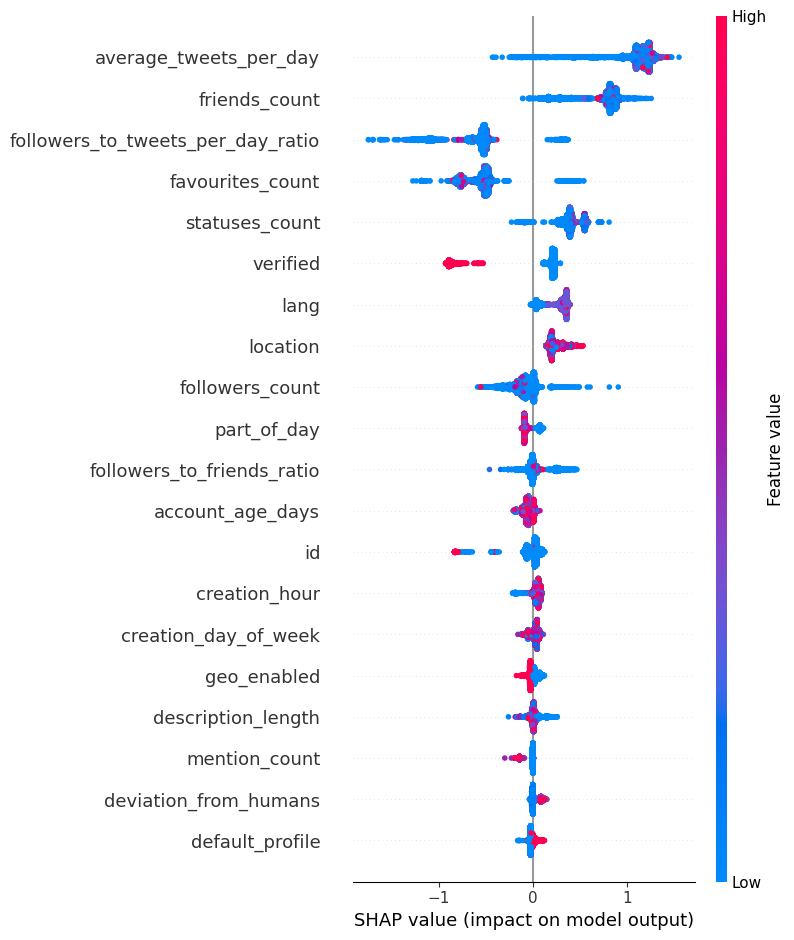

In [171]:
import shap

# Load the model from the pickle file
loaded_model = trainer.load_model('output_files/{0}_best_model.pkl'.format('xgb')) # change model type here

# Assuming you have your data prepared
explainer = shap.Explainer(loaded_model)
test = df[df['X_fold'] == 'test']
X_test = test[features]
y_test = test[target]    
shap_values = explainer(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)


# Local SHAP Explainability

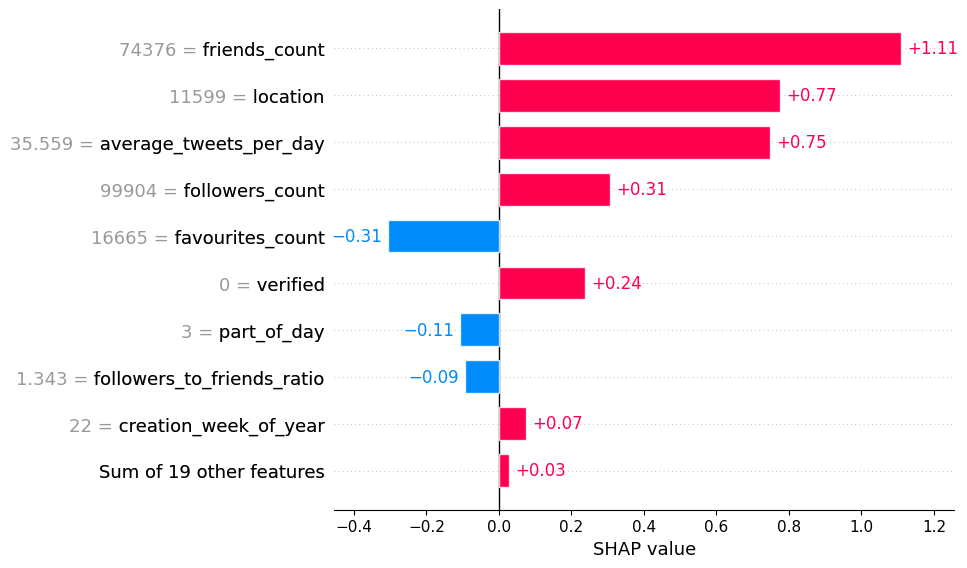

In [87]:
#shap.plots.bar(shap_values)
shap.plots.bar(shap_values[0])


# HUNOD
- K-means clustering
- Auto encoder
- Meta learner of Decision tree